In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


import os, glob
from pathlib import Path

from dandi import dandiapi
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
from nwbwidgets.view import default_neurodata_vis_spec

import pynwb
from nwbwidgets import nwb2widget


from typing import Union, Iterator, Callable, Tuple, Dict
import os
from pathlib import Path
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
# define functions to download files with a progress bar
MAX_CHUNK_SIZE = int(os.environ.get("DANDI_MAX_CHUNK_SIZE", 1024 * 1024 * 8))  

def get_download_file_iter_with_steps(
    file, chunk_size: int = MAX_CHUNK_SIZE
) -> Tuple[Callable[[int], Iterator[bytes]], Dict[str, int]]:

    url = file.base_download_url
    steps_dict = {"total_steps": None}
    result = file.client.session.get(url, stream=True)

    total_size = int(result.headers.get('content-length', 0))
    steps_dict["total_steps"] = total_size // chunk_size
    print(f"Downloading {total_size} bytes in {steps_dict['total_steps']} steps")

    def downloader(start_at: int = 0) -> Iterator[bytes]:
        headers = None
        if start_at > 0:
            headers = {"Range": f"bytes={start_at}-"}
        result = file.client.session.get(url, stream=True, headers=headers)
        result.raise_for_status()
        for chunk in result.iter_content(chunk_size=chunk_size):
            if chunk:  
                yield chunk

    return downloader, steps_dict

def download_with_progressbar(
    file, filepath: Union[str, Path], chunk_size: int = MAX_CHUNK_SIZE
) -> None:
    downloader, steps_dict = get_download_file_iter_with_steps(file)
    with open(filepath, "wb") as fp:
        for chunk in tqdm(downloader(0), total=steps_dict["total_steps"], unit="chunk", unit_scale=True, unit_divisor=1024):
            fp.write(chunk)

### Downloading The Ecephys File

In [4]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="config.env")

download_loc = os.getenv("DATA_DIR")
print(download_loc)


/Volumes/My Passport/001568


### Open and Display the NWB file

In [34]:
# open the downloaded NWB file
ROOT_DIR = download_loc

# Look for the first NWB file under the dandiset folder
candidates = glob.glob(str(Path(ROOT_DIR) / "**" / "*.nwb"), recursive=True)
if not candidates:
    raise FileNotFoundError("No .nwb file found under " + ROOT_DIR)
nwb_path = candidates[0]
print("Opening:", nwb_path)

io = NWBHDF5IO(nwb_path, "r", load_namespaces=True)

# number of neurons per probe per mouse that pass the threshold (r-squared of 0.5)
# basic statistics of how many good receptive fields, plotted, percent of total receptive fields that passed per probe per mouse


Opening: /Volumes/My Passport/001568/sub-813810/sub-813810_ses-ecephys-813810-2025-08-05-14-28-23_ecephys.nwb


In [58]:
num = nwb_path.split("-")[1]
subject_num = num.split("/")[0]

In [6]:
nwb = io.read()
print(nwb)

root pynwb.file.NWBFile at 0x5385597808
Fields:
  acquisition: {
    raw_running_wheel_rotation <class 'pynwb.base.TimeSeries'>,
    running_wheel_signal_voltage <class 'pynwb.base.TimeSeries'>,
    running_wheel_supply_voltage <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Device <class 'pynwb.device.Device'>,
    ProbeA <class 'pynwb.device.Device'>,
    ProbeB <class 'pynwb.device.Device'>,
    ProbeC <class 'pynwb.device.Device'>,
    ProbeE <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ProbeA <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeB <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeC <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeE <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  file_create_date: [datetime.datetime(2025, 8, 7, 20, 15, 38, 564352, tzinfo=tzutc())]
  identifier: 1ef67edb-fc1a-4334-95eb-9f52b12d7e31
  institution: Allen Institute for Neural Dynamics
  intervals: {
    drifti

### Extract Gabor Patches

In [35]:
# dict_keys([
#   'drifting_gratings_field_block_presentations',
#   'flash_field_block_presentations',
#   'receptive_field_block_presentations',
#   'spontaneous_presentations'
# ])

blocks = {
    "Gabor patches": "receptive_field_block_presentations",
    "Drifting gratings": "drifting_gratings_field_block_presentations",
    "Flash": "flash_field_block_presentations",
    "Spontaneous": "spontaneous_presentations",
}

pairing = {}


for i in blocks:
    pairing[i] = {"Trials": None, "Time": None}
    rf = nwb.intervals[blocks[i]] # this is where the gabor patches live
    df = rf.to_dataframe() # each row is 1 gabor stimulus representation
    gabor_trials_num = len(df)
    df['duration'] = df['stop_time'] - df['start_time']
    total_gabor_time = df['duration'].sum()
    print(f"{i} : {gabor_trials_num} trials = {total_gabor_time} minutes")
    pairing[i]["Trials"] = gabor_trials_num
    pairing[i]["Time"] = total_gabor_time

    # df.head() # peak at the first 5 rows (just for reference/debugging purposes)

Gabor patches : 4860 trials = 1216.0853305697801 minutes
Drifting gratings : 1500 trials = 1501.3410120554756 minutes
Flash : 300 trials = 75.06292056977782 minutes
Spontaneous : 2 trials = 21.267814572664747 minutes


In [36]:
# check that pairings is correct
pairing

{'Gabor patches': {'Trials': 4860, 'Time': 1216.0853305697801},
 'Drifting gratings': {'Trials': 1500, 'Time': 1501.3410120554756},
 'Flash': {'Trials': 300, 'Time': 75.06292056977782},
 'Spontaneous': {'Trials': 2, 'Time': 21.267814572664747}}

### Create Bar Graph 

In [37]:
labels = list(pairing.keys())
times = [round(pairing[label]["Time"]) for label in labels] # round the times just for simplicity
for i in range(len(labels)):
    print(f"{labels[i]}: {times[i]} minutes")

Gabor patches: 1216 minutes
Drifting gratings: 1501 minutes
Flash: 75 minutes
Spontaneous: 21 minutes


Text(0.5, 1.4, 'Gabor patches: 4860 Trials = 1216 Minutes\nDrifting gratings: 1500 Trials = 1501 Minutes\nFlash: 300 Trials = 75 Minutes\nSpontaneous: 2 Trials = 21 Minutes\nTotal: 2813 Minutes')

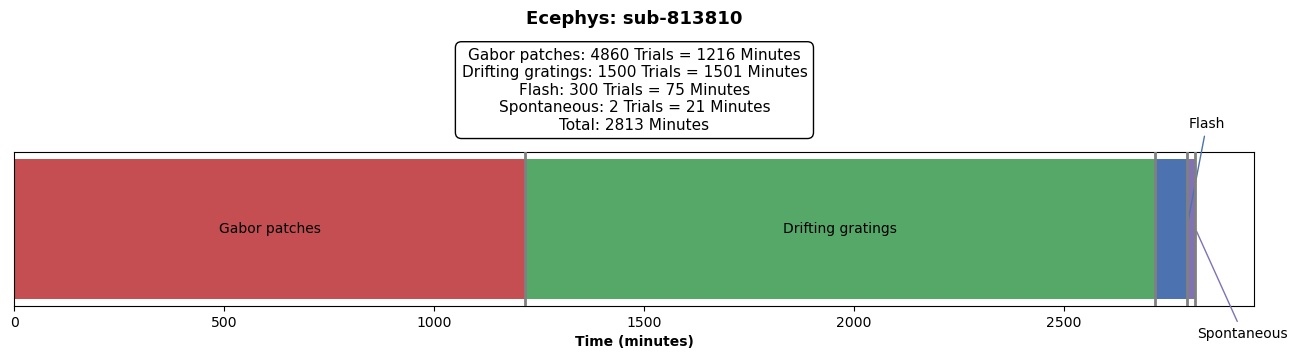

In [68]:
colors = [
    "#C44E52",  # red
    "#55A868",  # green
    "#4C72B0",  # blue
    "#8172B3",  # purple
]

plt.figure(figsize=(16, 2))
plt.title(f"Ecephys: sub-{subject_num}", y = 1.65, fontsize=13, fontweight="bold", pad=20)

left = 0  # where the current segment starts

MIN_WIDTH_FOR_INSIDE = 100

label_slots = [0.6, -0.6, 1.0, -1.0]
used_slots = []

for label, time, color in zip(labels, times, colors):
    plt.barh(
        y=0,
        width=time,
        left=left,
        color=color,
        edgecolor="none"
    )

    center_x = left + time / 2

    plt.axvline(
        x=left + time,
        color="gray",
        linewidth=2,
        zorder=5
    )

    if time >= MIN_WIDTH_FOR_INSIDE:
        # Inside label
        plt.text(
            center_x,
            0,
            label,
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

    else:
        # Choose a free slot
        for slot in label_slots:
            if slot not in used_slots:
                y_offset = slot
                used_slots.append(slot)
                break
        else:
            # Fallback: stack higher if all slots used
            y_offset = max(label_slots) + 0.4
            label_slots.append(y_offset)
            used_slots.append(y_offset)

        plt.annotate(
            label,
            xy=(left + time, 0),
            xytext=(left + time + 5, y_offset),
            ha="left",
            va="center",
            fontsize=10,
            arrowprops=dict(
                arrowstyle="-",
                color=color,
                lw=1
            )
        )

    left += time
plt.yticks([])
plt.xlabel("Time (minutes)", fontweight = "bold")

# add a summary box
summary_text = ""
summed = 0
for i in pairing:
    summary_text += f"{i}: {pairing[i]['Trials']} Trials = {round(pairing[i]['Time'])} Minutes\n"
    summed += round(pairing[i]['Time'])
summary_text += f"Total: {summed} Minutes"




plt.text(
    0.5, 1.4,                      
    summary_text,
    transform=plt.gca().transAxes, 
    ha="center",
    va="center",
    fontsize=11,
    #fontweight="bold",
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="white",
        edgecolor="black"
    )
)
